# Difference Equations & Iteration

This jupyter notebook is part of Arizona State University's course CAS 570 (Introduction to Complex Systems Science) and was written by Enrico Borriello. It was last updated September 30, 2024.

____

In this example, we model a dynamical system using difference equations. Difference equations are an appropriate approach when the time variable in our model can realistically be updated in discrete steps.

For simplicity, we will refer to the SIR model (see the corresponding notebook in this repository for a full description of the model). The SIR model is usually described using ordinary differential equations (ODEs). In this notebook, we will explore how a system of ODEs can be converted into a discrete-time system, which iteratively generates a time series representing the evolution of the system. Alternatively, your model might be better suited for a discrete step time update from the start.

The main learning objective of this example is to recognize a common issue that arises when coding the updating rule for multiple variables. Since the updates are always done sequentially, using the most recent value of a variable in the middle of the update process can introduce errors. Specifically, some variables may already refer to the state at time step t+1, while others are still in their state at time t. Let's explore this issue in practice.

A discrete version of the SIR model can be described by the following system of equations:

$$S_{t+1} = S_{t} - c S_{t}I_{t}$$

$$I_{t+1} = I_{t} + c S_{t}I_{t} - r I_{t}$$

$$R_{t+1} = R_{t} + r I_{t}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Approach 1: The wrong method

In [2]:
c = 0.001
r = 0.05

S0 = 999
I0 = 1
R0 = 0

T = 100

S = [S0]
I = [I0]
R = [R0]

for t in range(T):
    S.append(S[-1]-c*S[-1]*I[-1])
    I.append(I[-1]+c*S[-1]*I[-1]-r*I[-1])
    R.append(R[-1]+r*I[-1])

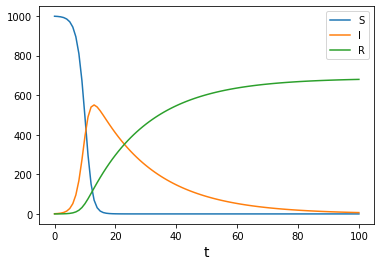

In [3]:
plt.plot(range(T+1),S,label='S')
plt.plot(range(T+1),I,label='I')
plt.plot(range(T+1),R,label='R')
plt.xlabel('t',size=14)
plt.legend()
plt.show()

While this result might seem correct at a first glance, it is not. While our equations are supposed to preserve the total number of individuals, because

$$ S_{t+1} + I_{t+1} + R_{t+1} = S_t + I_t + R_t \ , $$ 

the way we are implementing them numerically doesn't. In particular

In [4]:
print('initial population size = ',S[0]+I[0]+R[0])
print('final population size   = ',S[-1]+I[-1]+R[-1])

initial population size =  1000
final population size   =  686.6363724035141


We can understand what's happening by comparing the values of the term $c S_t I_t$ in the first and the second line of our for-loop. The two terms should be the same. Let's run our code for just one time step:

In [5]:
c = 0.001
r = 0.05

S0 = 999
I0 = 1
R0 = 0

T = 1

S = [S0]
I = [I0]
R = [R0]

for t in range(T):
    print('S = ',S[-1])
    print('Before updating S, c*S*I  = ',c*S[-1]*I[-1])
    print('Then S is updated')
    S.append(S[-1]-c*S[-1]*I[-1])
    print('S = ',S[-1])
    print('After updatinfg S, and before updating I, c*S*I  = ',c*S[-1]*I[-1])
    I.append(I[-1]+c*S[-1]*I[-1]-r*I[-1])
    R.append(R[-1]+r*I[-1])

S =  999
Before updating S, c*S*I  =  0.999
Then S is updated
S =  998.001
After updatinfg S, and before updating I, c*S*I  =  0.998001


The mistake is that we're using S[0] in updating S, but S[1] in updating I. For the same reason, we also use I[1] instead of I[0] in updating R when running the 3rd line. This little mistake is cumulative, and eventually leads to about 313 people disappearing from the total population.

To avoid this mistake we need to make sure we are always reading the values of $S$, $R$, and $I$ at time $t$ when evaluating these variables at time $t+1$.

Here's an option where we explicitly correct the two places where we were making a mistake:

### Approach 2: Correct, but using *hardcoding*

In [6]:
c = 0.001
r = 0.05

S0 = 999
I0 = 1
R0 = 0

T = 100

S = [S0]
I = [I0]
R = [R0]

for t in range(T):
    S.append(S[-1]-c*S[-1]*I[-1])
    I.append(I[-1]+c*S[-2]*I[-1]-r*I[-1])
    R.append(R[-1]+r*I[-2])

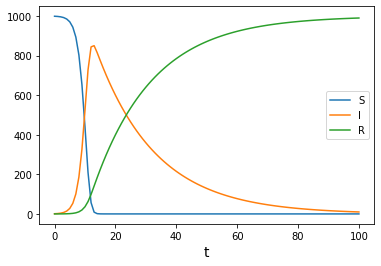

initial population size =  1000
final population size   =  1000.0


In [7]:
plt.plot(range(T+1),S,label='S')
plt.plot(range(T+1),I,label='I')
plt.plot(range(T+1),R,label='R')
plt.xlabel('t',size=14)
plt.legend()
plt.show()

print('initial population size = ',S[0]+I[0]+R[0])
print('final population size   = ',S[-1]+I[-1]+R[-1])

This approach of referring to the second last update of just the variables that have been already updated is not very convenient with many more variables. This sort of *hardcoding* makes coding mistakes a lot more likely.

### Approach 3: The safer method

A better way consists in giving new names to the variables while we update them, and then rename all of them *at the same time:*

In [8]:
c = 0.001
r = 0.05

S0 = 999
I0 = 1
R0 = 0

T = 100

S = [S0]
I = [I0]
R = [R0]

for t in range(T):
    S1 = S[-1]-c*S[-1]*I[-1]
    I1 = I[-1]+c*S[-1]*I[-1]-r*I[-1]
    R1 = R[-1]+r*I[-1]
    S.append(S1)
    R.append(R1)
    I.append(I1)

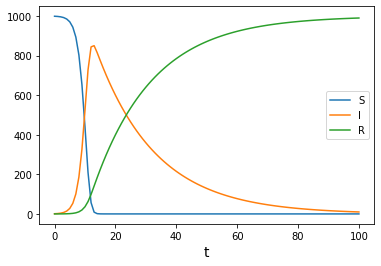

initial population size =  1000
final population size   =  1000.0


In [9]:
plt.plot(range(T+1),S,label='S')
plt.plot(range(T+1),I,label='I')
plt.plot(range(T+1),R,label='R')
plt.xlabel('t',size=14)
plt.legend()
plt.show()

print('initial population size = ',S[0]+I[0]+R[0])
print('final population size   = ',S[-1]+I[-1]+R[-1])

Using the more compact approach we adopted in the continuos version of the model, where a vector $x = [S,R,I]$ collects all the dynamic variables, we can write our code as

In [10]:
c = 0.001
r = 0.05

S0 = 999
I0 = 1
R0 = 0

x0 = [S0,I0,R0]

In [11]:
def SIRupdate(c, r, x):
    # the analogous of running odeint
    
    S = x[0]
    I = x[1]
    R = x[2]

    S_1 = S - c*S*I
    I_1 = I + c*S*I - r*I
    R_1 = R + r*I
    
    S = S_1
    I = I_1
    R = R_1
    
    return [S,I,R]

In [12]:
x = [x0]
T = 100
for t in range(T):
    x.append(SIRupdate(c,r,x[-1]))

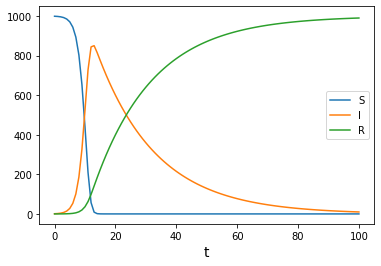

initial population size =  1000.0
final population size   =  1000.0


In [13]:
S = np.array(x).T[0]
R = np.array(x).T[1]
I = np.array(x).T[2]

plt.plot(range(T+1),S,label='S')
plt.plot(range(T+1),R,label='I')
plt.plot(range(T+1),I,label='R')
plt.xlabel('t',size=14)
plt.legend()
plt.show()

print('initial population size = ',S[0]+I[0]+R[0])
print('final population size   = ',S[-1]+I[-1]+R[-1])